# Stroke Prediction Project with python

## References:

- https://www.kaggle.com/oumarkane/stroke-prediction
- https://www.kaggle.com/calebreigada/stroke-prediction-with-neural-networks-data-viz
- https://www.kaggle.com/sanjoymondal0/stroke-prediction-accuracy-96/notebook
- https://github.com/nurahmadi/Stroke-prediction-with-ML/blob/master/Stroke%20Prediction%20and%20Analysis%20-%20Notebook.ipynb
- https://github.com/soumyavk/Stroke-Prediction-Model/blob/main/Stroke_analysis_and_prediction.ipynb

## Problem Statement

 According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Source - Kaggle - Stroke Prediction Dataset

## Objective :

- Predict whether a patient will have a heart stroke or not based on his/her comorbidity, work and lifestyle.
- Determine what makes a person at risk for stroke.
- Create a machine learning model to perform early detection of stroke for patients.

## Data Understanding

**Features** :
1. id: unique identifier
2. gender: “Male”, “Female” or “Other”
3. age: age of the patient
4. hypertension: 0 if the patient does not have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient does not have any heart diseases, 1 if the patient has a heart disease
6. ever_married: “No” or “Yes”
7. work_type: “children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
8. Residence_type: “Rural” or “Urban”
9. avg_glucose_level: average glucose level in blood
10. BMI: body mass index
11. smoking_status: “formerly smoked”, “never smoked”, “smokes” or “Unknown”*
12. stroke: 1 if the patient had a stroke or 0 if not

In [6]:
!pip install imblearn

     |████████████████████████████████| 199 kB 30.9 MB/s            
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [7]:
# Importing all the relevant packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import shutil
import seaborn as sns
# from pandas_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Steps

* [Data Load](#data-load)
* [data analyze](#data-analyse)
* [data preprocessing](#data-preprocessing)
    * [process categorical features](#categorial-feature)
    * [remove unnecessary features](#remove-features)
    * [process missing data](#missing-data)
    * [balanced target data classes](#balanced-dataset)
* [save processed data](#save)
* [split data for training](#split-dataset)
* [implement the ML model](#ml-model)
* [train model](#train-model)
* [evaluate model](#evaluate-model)
* [conclusion](#conclusion)


## Data Load <a name="data-load"></a>

In [8]:
# copy raw data to processed folder :
raw_data_path = "data/raw/"
processed_data_path = "data/processed/"
data_filename = "healthcare-dataset-stroke-data.csv"

def load_data(raw, processed, data_name, verbose=False):
    """
    Load processed data if file doesn't exist else Copy a .csv file from raw data folder to processed data folder 
    and load it.
    params:
    - raw_data_path: string, path to raw data
    - processed_data_path: string, path to processed data folder
    - data_filename: string, data name
    - verbose: bool,  to print dataset information
    return:
    - data: .csv data processed
    """
    # check if processed data file is empty:
    if len(os.listdir(processed)) == 0:
        # copy data raw
        shutil.copyfile(raw + data_name, processed + data_name)
    data_loaded = pd.read_csv(processed + data_name)
    if verbose:
        print("Data '{}' loaded with data shape: {}".format(data_name, data_loaded.shape))
    return data_loaded

data = load_data(raw_data_path, processed_data_path, data_filename, verbose=True)
print(data.describe())  # displays stats about the numerical features
print(data.info())

Data 'healthcare-dataset-stroke-data.csv' loaded with data shape: (5110, 11)
            gender          age  hypertension  heart_disease  ever_married  \
count  5110.000000  5110.000000   5110.000000    5110.000000   5110.000000   
mean      0.414286    43.226614      0.097456       0.054012      0.656164   
std       0.493044    22.612647      0.296607       0.226063      0.475034   
min       0.000000     0.080000      0.000000       0.000000      0.000000   
25%       0.000000    25.000000      0.000000       0.000000      0.000000   
50%       0.000000    45.000000      0.000000       0.000000      1.000000   
75%       1.000000    61.000000      0.000000       0.000000      1.000000   
max       2.000000    82.000000      1.000000       1.000000      1.000000   

         work_type  Residence_type  avg_glucose_level          bmi  \
count  5110.000000     5110.000000        5110.000000  5110.000000   
mean      2.167710        0.508023         106.147677    28.893237   
std       

In [85]:
def save_df_csv(df, directory, file_name, verbose=False):
    """
    Save dataframe csv file in "directory/file_name.csv".
    params :
    - directory : target directory to save csv file.
    - file_name : csv dataframe name.
    """
    df.to_csv(directory + file_name, index=False)
    if verbose:
        print("dataframe saved in: {}{} directory".format(directory, file_name))
    return

## Data analyse <a name="data-analyse"></a>

### Missing and duplicated values

In [74]:
# missing values
miss_values = data.isna().sum()/len(data)*100  # displays amount of null values for each column
print(miss_values)
print(data.duplicated().sum())

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64
0


There are no redundant values.

There are one variable that contains missing values: bmi (3.93%).
For missing values in "bmi" we will replace them with the average of "bmi" values because there are not a lot of missing values.

Visualize missing values repartition :

In [8]:
px.imshow(data.isna())

Unsupported

The missing values are well distributed and represent only 4% of the data. Therefore, they can either be replaced by the mean value or by the most frequent value.
We choose to replace the missing values with the mean

In [75]:
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())  # fill 'bmi' NaN values using 'bmi' mean
data = data.drop('id',axis=1)  # remove id columns
save_df_csv(data, processed_data_path, data_filename, verbose=True)

print(data.axes)
print(data.nunique())

dataframe saved in: data/processed/healthcare-dataset-stroke-data.csv directory
[RangeIndex(start=0, stop=5110, step=1), Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')]
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64


In [76]:
# Now missing values:
miss_values = data.isna().sum()/len(data)*100  # displays amount of null values for each column
print(miss_values)
print(data.duplicated().sum())

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
0


### Variables repartition

Percent of patients in dataset with stroke: 0    95.1272
1     4.8728
Name: stroke, dtype: float64%


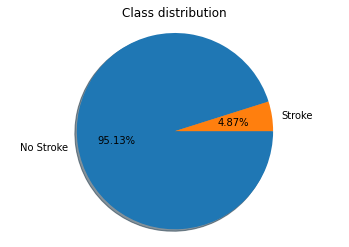

In [77]:
#display percent of dataset with stroke
percentage_stroke = data['stroke'].value_counts(normalize = True)*100
class_names = ['No Stroke','Stroke']
print('Percent of patients in dataset with stroke: {}%'.format(round(percentage_stroke, 4)))

fig, ax = plt.subplots()
ax.pie(percentage_stroke, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

Transformation categorical data type.
Apply the label encoding for categorical columns:

In [78]:
# data type identification:
print(data.dtypes)

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [79]:
categorical_columns = data.select_dtypes('object').columns
print(categorical_columns)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [80]:
# Encode target labels with value between 0 and n_classes-1.
# LabelEncoder can be used to normalized labels.abs

def label_encoding(label):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    data[label] = label_encoder.fit_transform(data[label])
    data[label].unique()

In [81]:
for column in categorical_columns:
    label_encoding(column)

save_df_csv(data, processed_data_path, data_filename, verbose=True)
print(data.dtypes)

dataframe saved in: data/processed/healthcare-dataset-stroke-data.csv directory
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object


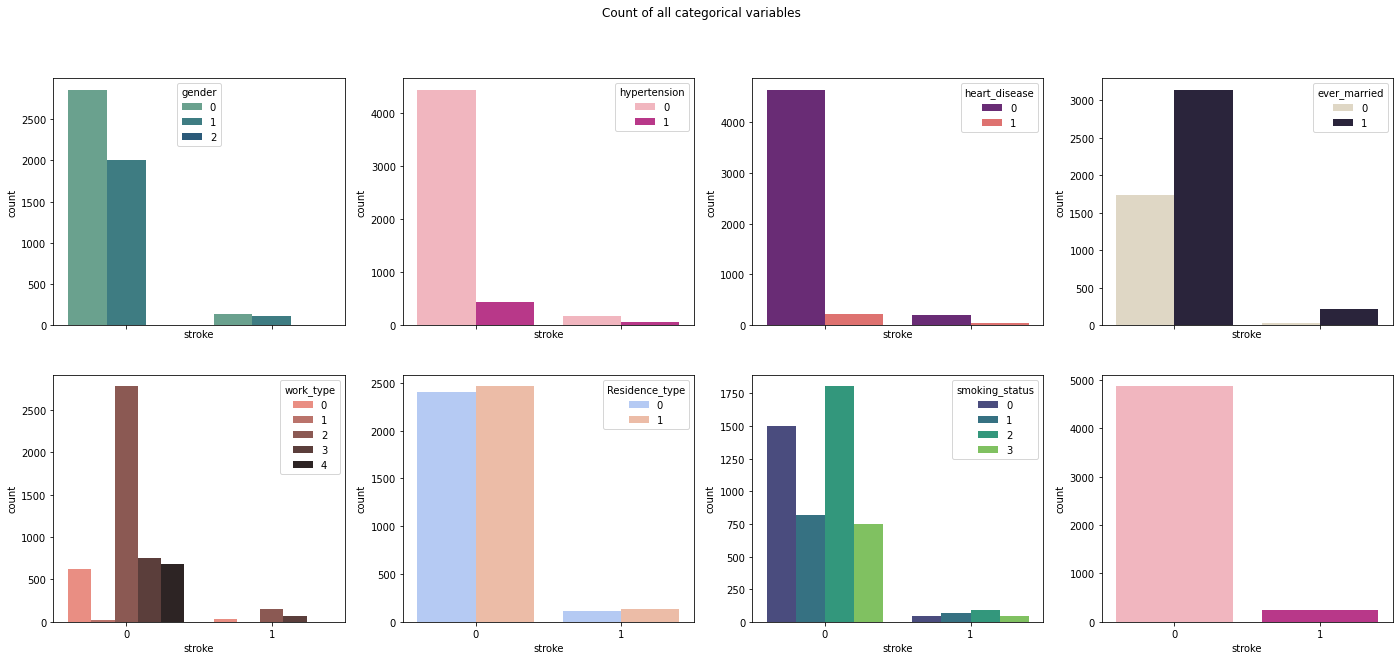

In [20]:
# all variable proportions :
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(24,10))
fig.suptitle('Count of all categorical variables')
sns.countplot(ax=axes[0, 0], data=data, x='stroke',hue = 'gender',palette='crest')
sns.countplot(ax=axes[0, 1], data=data, x='stroke',hue='hypertension',palette='RdPu')
sns.countplot(ax=axes[0, 2], data=data, x='stroke',hue = 'heart_disease',palette='magma')
sns.countplot(ax=axes[0, 3], data=data, x='stroke',hue = 'ever_married',palette="ch:s=-.2,r=.6")
sns.countplot(ax=axes[1,0],data = data, x ='stroke' ,hue = 'work_type',palette="dark:salmon_r")
sns.countplot(ax=axes[1,1],data = data, x ='stroke',hue='Residence_type',palette="coolwarm" )
sns.countplot(ax=axes[1,2],data = data, x ='stroke',hue='smoking_status',palette='viridis' )
sns.countplot(ax=axes[1,3],data = data, x ='stroke',palette='RdPu' )
plt.show()

Only about 5% of the patients in the dataset experienced a stroke. It makes creating out model more difficult.

The number of valid people is much lower than the other one. Therefor, using accuracy metric is not relevant. We will use other metrics such as:
- Recall: $\frac{TP}{TP+FN}$. Calculates the percentage of positive tests among actual stroke patients.
- Precision: $\frac{TP}{TP+FN}$. Calculate the percentage of patients who are actually ill among those who test positive.
- F1-score: $\frac{2*recall*precision}{recall+precision}$.

Confusion matrix to visualize the relationship between the explanatory variables and the target variable.

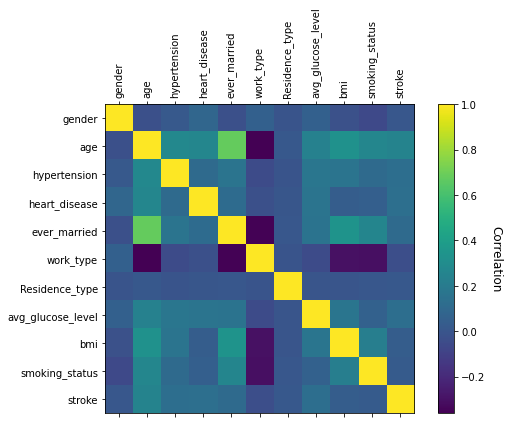

In [21]:
# inter-feature correlation:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(data.corr())
ax.set_xticks(np.arange(data.shape[1]))
ax.set_yticks(np.arange(data.shape[1]))
ax.set_xticklabels(data.columns,rotation=90)
ax.set_yticklabels(data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

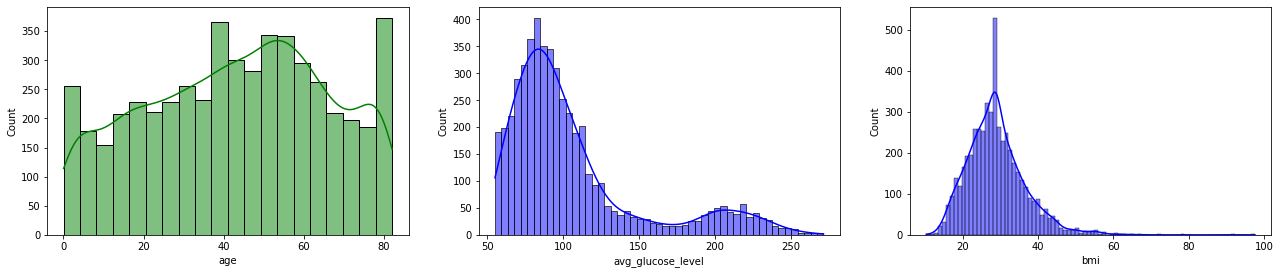

In [22]:
# no categorical variable distribution:
no_categorical_columns = ["age", "avg_glucose_level", "bmi"]

fig, axs = plt.subplots(1, 3, figsize = (18, 4))
axs = axs.flat

for i, column in enumerate(no_categorical_columns):
    fig.tight_layout(w_pad = 3, pad = 1.2)
    color = "green" if i == 0 else "blue" 
    sns.histplot(data = data, x = column, kde = True, ax = axs[i], color = color)
    

### Pandas Profiling:

In [17]:
# profile = ProfileReport(data_frame, title = "Investigation avec Pandas Profiling")

### Feature selection with SelectKBest algorithm.

This function select the k features with the highest score_fucntion score, here is chi2.
Chi2: a chi-square test is a statistical test used to compare observed results with expected results. The purpose of this test is to determine if a difference between observed data and expected data is due to chance, or if it is due to a relationship between the variables you are studying.

Here we use the function to find out but it is not useful because k=10 is the number of all our variables, we do not need to select the first k variables.

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [24]:
x = data.drop('stroke',axis=1)
y = data['stroke']

print(x.shape, y.shape)

(5110, 10) (5110,)


In [25]:
ordered_rank_features = SelectKBest(score_func=chi2, k=10)
ordered_feature = ordered_rank_features.fit(x,y)

dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
dfcolumns = pd.DataFrame(x.columns)

features_rank = pd.concat([dfcolumns, dfscores], axis=1)
features_rank.columns = ['Features', 'Score']
# print(features_rank)

print(features_rank.nlargest(10, 'Score'))

            Features        Score
1                age  3635.226911
7  avg_glucose_level  1718.285446
3      heart_disease    87.987436
2       hypertension    75.449498
4       ever_married    20.622787
8                bmi    15.894122
9     smoking_status     3.369423
5          work_type     2.925901
6     Residence_type     0.600717
0             gender     0.239001


We observe that age variable is the most relevant variable for predicting stroke.
If, later, the model overfit we can remove one or more variables among: "residence_type", "work_type", "smoking_status", "bmi" or "ever_married".

### Relation between target et explicative variables:

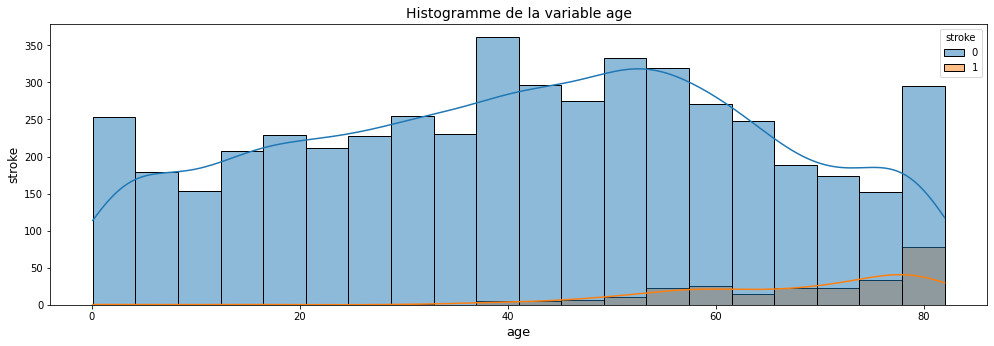

In [26]:
# non categorical variables / target:

plt.figure(figsize = (15, 6))
sns.histplot(data = data, x = "age", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable age", fontsize = 14)
plt.xlabel("age", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

We see that the two distributions are different. We see that older people are more likely to have a stroke.

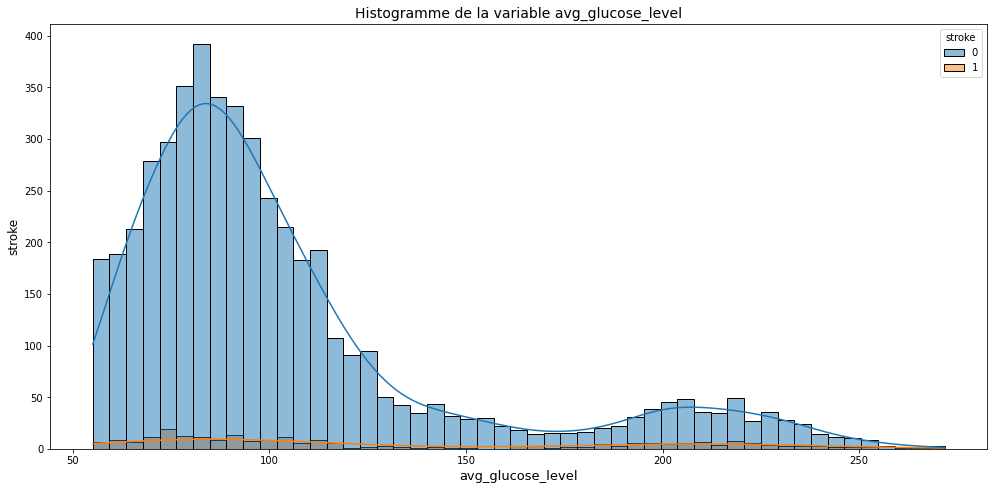

In [27]:
plt.figure(figsize = (15, 8))
sns.histplot(data = data, x = "avg_glucose_level", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable avg_glucose_level", fontsize = 14)
plt.xlabel("avg_glucose_level", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

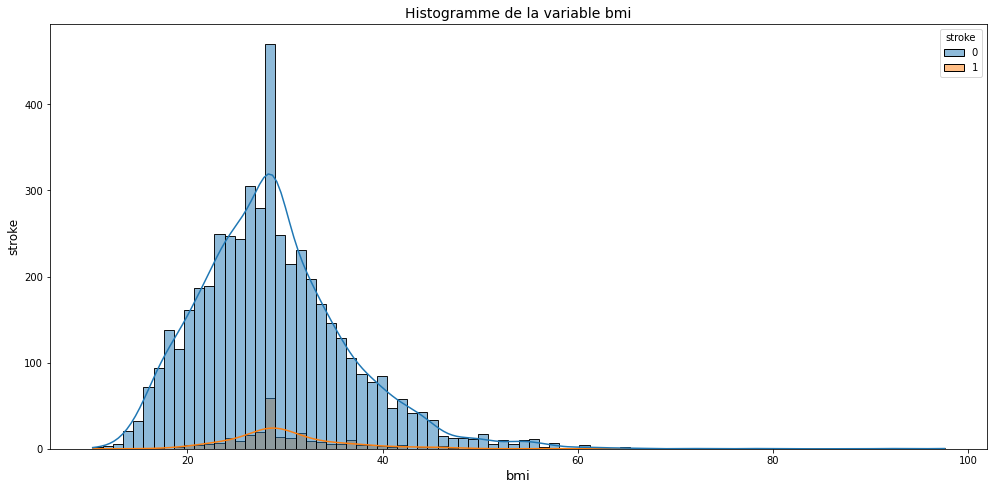

In [28]:
plt.figure(figsize = (15, 8))
sns.histplot(data = data, x = "bmi", hue = "stroke", kde = True, palette = "tab10")
plt.title(f"Histogramme de la variable bmi", fontsize = 14)
plt.xlabel("bmi", fontsize = 13)
plt.ylabel("stroke", fontsize = 12)
plt.tight_layout(pad = 5)

For "bmi" and "avg_glucose_level", the distributions are similar. We cannot therefore conclude on the relationship between these two variables and the target variable.

### Outliers:

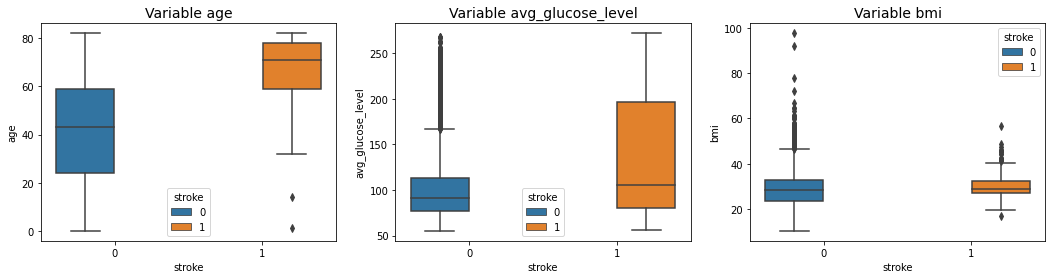

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (18, 4))
axs = axs.flat

for i,column in enumerate(no_categorical_columns):
    sns.boxplot(data=data, x="stroke", y=column, hue="stroke", ax=axs[i], palette="tab10")
    axs[i].set_title(f"Variable {column}", fontsize=14)

## Data Preprocessing: <a name="data-preprocessing"></a>

In [9]:
#removes labels from dataset
X, y = data.drop('stroke', axis=1).values, data['stroke'].values
print(X.shape, y.shape)

(5110, 10) (5110,)


### Data split <a name="split-dataset"></a>

In [10]:
#Splits the data into train, test, validate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
# print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 3832
Samples in Test Set: 1278


### Imbalanced dataset: <a name="balanced-dataset"></a>
[(source)](https://heartbeat.comet.ml/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa)

Synthetic Minority Oversampling Technique (SMOTE): by synthesising new samples from the minority class to have the same number of samples as the majority class.
Oversampling technique is chosen because we do not want to loose significant amount of information (97.88%) as if we use undersampling technique.

SMOTE stands for Synthetic Minority Oversampling Technique — it consists of creating or synthesizing elements or samples from the minority class rather than creating copies based on those that exist already. This is used to avoid model overfitting.

To create a synthetic instance, SMOTE finds the K-nearest neighbors of each minority instance, randomly selects one of them and then calculates linear interpolations to produce a new minority instance in the neighborhood. It can be also explained by changing this instance features one at a time by a random amount — so as a result, the new points are added between the neighbors.

In [11]:
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

# fit the object to our training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Displays perccent of each class
print('Initial Dataset')
print('Percent "stroke":', y_train.sum()/len(y_train))
print('Balanced Dataset')
print('Percent "stroke":', y_train_balanced.sum()/len(y_train_balanced))

X_train = X_train_balanced
y_train = y_train_balanced

Initial Dataset
Percent "stroke": 0.04801670146137787
Balanced Dataset
Percent "stroke": 0.5


### Data normalization:

In [12]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
# X_valid_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

X_train = X_train_std
# X_val = X_valid_std
X_test = X_test_std
#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
# print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 7296
Samples in Test Set: 1278


## ML model training and Evaluation

1. SVM
2. Gaussian Naive Bayes
3. Logistic Regression
4. Decision Tree
5. Random Forest
6. LightGBM
7. XGboost
8. Neural Network

### Performance Metrics :

1. Sensitivity, specificity, and area under the curve (AUC)
2. Precision, recall, and F1 score.

In [18]:
from sklearn.model_selection import cross_val_score

# python decorator to measure the execution time of methods:
def timeit(method):
    def timed(*args, **kw):
        time_start = time.time()
        result = method(*args, **kw)
        time_end = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((time_end - time_start) * 1000)
        else:
            print('{} {:.2f} ms'.format(method.__name__, (time_end - time_start)*1000))
        return result
    return timed

@timeit
def classifier_training(model, X, y):
    model.fit(X, y)


def calcul_sensitivity_speccitivity(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)    
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity


def compute_score(model, x_t, y_t, verbose=True):
    y_p = model.predict(x_t)
    y_p_proba = model.predict_proba(x_t)
    score = accuracy_score(y_t,y_p)
    if verbose:
        print("Accuracy score for {}: {:.2f}%".format(type(model).__name__, score*100))
    return y_p, y_p_proba, score

### SVM

In [14]:
# training model with train data
classifier_svm = SVC(kernel='rbf', random_state=0, probability=True)
classifier_training(classifier_svm, X_train, y_train)

classifier_training 5676.88 ms


In [19]:
# score:
y_pred, y_pred_proba, acc_svm = compute_score(classifier_svm, X_test, y_test)

Accuracy score for SVC: 87.95%


In [20]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_pred)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_pred)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_pred)))

Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1213
           1       0.11      0.20      0.14        65

    accuracy                           0.88      1278
   macro avg       0.53      0.56      0.54      1278
weighted avg       0.91      0.88      0.89      1278

Confusion matrix for SVM: 
[[1111  102]
 [  52   13]]
Accuracy score for SVM: 0.88


In [21]:
# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_pred)
rec_svm = recall_score(y_test,y_pred)
f1_svm = f1_score(y_test,y_pred)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))

Precision score for SVM: 0.11
Recall score for SVM: 0.20
F1 score for SVM: 0.14


Sensitivity score for SVM: 0.20
Specitivity score for SVM: 0.92
AUC score for SVM: 0.72


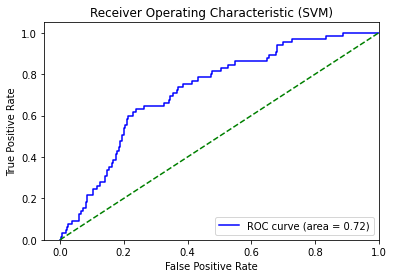

In [22]:
# calculate sensitivity, specificity, and auc
sens_svm,spec_svm = calcul_sensitivity_speccitivity(y_test,y_pred)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba[:,1])
auc_svm = roc_auc_score(y_test, y_pred_proba[:,1])
print("Sensitivity score for SVM: {:.2f}".format(sens_svm))
print("Specitivity score for SVM: {:.2f}".format(spec_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))

# plot ROC curve: 
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

### Logistic regression :

In [23]:
from sklearn.linear_model import LogisticRegression

classifier_logistic_regression = LogisticRegression(random_state = 0)
classifier_training(classifier_logistic_regression, X_train, y_train)

classifier_training 20.71 ms


In [24]:
# score:
y_pred_log_reg, _, acc_log_reg = compute_score(classifier_logistic_regression, X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
print(cm)

Accuracy score for LogisticRegression: 75.59%
[[918 295]
 [ 17  48]]


### KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier_training(classifier_knn, X_train, y_train)

classifier_training 9.14 ms


In [26]:
# score:
y_pred_knn, _, acc_knn = compute_score(classifier_knn, X_test, y_test)

# prediction
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

Accuracy score for KNeighborsClassifier: 85.45%
[[1071  142]
 [  44   21]]


### Gaussian Naive Bayes Classification

In [27]:
from sklearn.naive_bayes import GaussianNB
classifier_bayes = GaussianNB()
classifier_training(classifier_bayes, X_train, y_train)

classifier_training 2.58 ms


In [28]:
# score:
_, _, acc_bayes = compute_score(classifier_bayes, X_test, y_test)

Accuracy score for GaussianNB: 73.24%


### Decision tree classification

In [29]:
from sklearn.tree import DecisionTreeClassifier
classifier_decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)
classifier_training(classifier_decision_tree, X_train, y_train)

classifier_training 31.98 ms


In [30]:
# score:
_, _, acc_decision_tree = compute_score(classifier_decision_tree, X_test, y_test)

Accuracy score for DecisionTreeClassifier: 90.45%


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

classifier_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_training(classifier_random_forest, X_train, y_train)

classifier_training 861.53 ms


In [32]:
# score:
_, _, acc_random_forest = compute_score(classifier_random_forest, X_test, y_test)

Accuracy score for RandomForestClassifier: 94.37%


### LightGBM (LGBM)

In [33]:
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 26.8 MB/s            
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [34]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier(n_estimators=100, random_state=42)
classifier_training(classifier_lgbm, X_train, y_train)

classifier_training 179.23 ms


In [35]:
# score:
_, _, acc_lgbm = compute_score(classifier_lgbm, X_test, y_test)

Accuracy score for LGBMClassifier: 94.29%


### XGBoost (XGB)

In [36]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(objective="binary:logistic", random_state=42)
classifier_training(classifier_xgb, X_train, y_train)

[02:40:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
classifier_training 829.86 ms


/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [37]:
# score:
_, _, acc_xgb = compute_score(classifier_xgb, X_test, y_test)

Accuracy score for XGBClassifier: 93.58%


## Models Accuracy resume

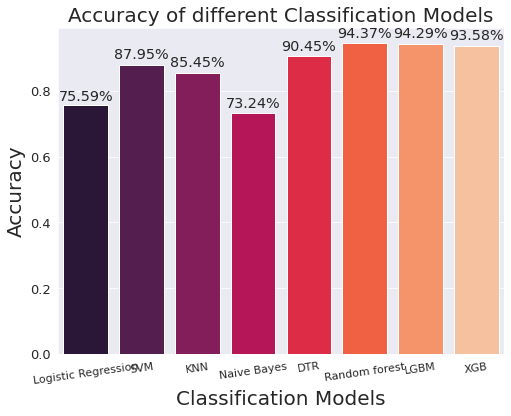

In [38]:
acc=[]
models=[]

acc.append(acc_log_reg)
models.append("Logistic Regression")
acc.append(acc_svm)
models.append("SVM")
acc.append(acc_knn)
models.append("KNN")
acc.append(acc_bayes)
models.append("Naive Bayes")
acc.append(acc_decision_tree)
models.append("DTR")
acc.append(acc_random_forest)
models.append("Random forest")
acc.append(acc_lgbm)
models.append("LGBM")
acc.append(acc_xgb)
models.append("XGB")

plt.rcParams['figure.figsize']=8,6
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=acc, palette = "rocket", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## Conclusion

- model choice?
- most relevent features to predict stroke?
- what next?
    - optimization model?
    - cross validation? why? (maybe to see if the chosen model is robust?)
    - gridsearch?